In [27]:
# Numpy
import numpy as np
import scipy as sc

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse
from utils.sqrtm import sqrtm
from utils.utils import AverageMeter, DCN

In [41]:
def data_loader(file_num, batch_size):
    # (# of trajectories, length of trajectory, # of dimension)
    with open(f'./data/train/trj_{file_num}.npy', 'rb') as f:
        train_data = np.load(f)
    with open(f'./data/test/trj_{file_num}.npy', 'rb') as f:
        test_data = np.load(f)
        
    data_dim = train_data.shape[-1]
    train_data = TensorDataset(torch.FloatTensor(train_data[:, :-1].reshape(-1, data_dim)), 
                               torch.FloatTensor(np.diff(train_data, axis=-2).reshape(-1, data_dim)))
    test_data = TensorDataset(torch.FloatTensor(test_data[:, :-1].reshape(-1, data_dim)), 
                              torch.FloatTensor(np.diff(test_data, axis=-2).reshape(-1, data_dim)))

    train_loader = DataLoader(
                train_data,
                batch_size=batch_size,
                shuffle=True,
                pin_memory=True,

            )
    test_loader = DataLoader(
                test_data,
                batch_size=batch_size * 10,
                shuffle=False,
                pin_memory=True,
            )
        
    return train_loader, test_loader

In [26]:
train_data

array([[[ 0.04572005, -0.16639942,  0.08162145, -0.25287022,
          0.17916458,  0.20715036],
        [-0.01067984, -0.10520259,  0.16201571, -0.20057106,
          0.21764147,  0.28348719],
        [-0.14934827, -0.2945477 ,  0.01161893, -0.30278999,
          0.16171056,  0.16309485],
        ...,
        [-0.69608797, -0.05808309, -0.12353774,  0.53194732,
         -0.90534732, -0.07462789],
        [-0.706605  , -0.00668464, -0.07896566,  0.41026472,
         -0.72935561, -0.13749651],
        [-0.57395929,  0.14400042, -0.25864431,  0.50671012,
         -0.53038297, -0.26966158]],

       [[ 0.08372636,  0.02073531,  0.08274095, -0.06204761,
         -0.18821667, -0.11474728],
        [ 0.12622045,  0.15451571,  0.01241575, -0.02028146,
         -0.18077275, -0.12240961],
        [ 0.41304495,  0.27121571, -0.0562031 , -0.195852  ,
         -0.16993914, -0.26060075],
        ...,
        [ 0.38676335, -0.01776034,  1.34890535, -0.01016844,
         -1.60598386, -0.44065379],
  

<IPython.core.display.Javascript object>


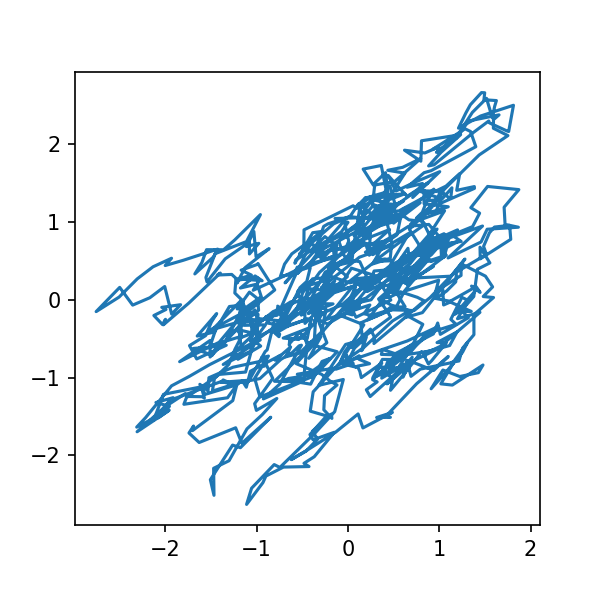

In [25]:
file_num = str(2)
# (# of trajectories, length of trajectory, # of dimension)
with open('./data/train/trj_'+ file_num + '.npy', 'rb') as f:
    train_data = np.load(f)
with open('./data/test/trj_'+ file_num + '.npy', 'rb') as f:
    test_data = np.load(f)
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
n = 21
t = 1000
ax.plot(train_data[n][:t, 0], train_data[n][:t, 1])

In [29]:
# Set random seed for reproducibility
SEED = 2589
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


class FieldLearning(nn.Module):
    def __init__(self, input_dim, output_dim, d, dt):
        super(FieldLearning, self).__init__()
        self.d = d  # space dimension
        self.dt = torch.tensor(dt)
        
        self.force_model = nn.Sequential(
            nn.Linear(input_dim, 256),            # [batch, 12, 16, 16]
            nn.ELU(),
            nn.Linear(256, 256),           # [batch, 24, 8, 8]
            nn.ELU(),
            nn.Linear(256, 256),           # [batch, 24, 8, 8]
            nn.ELU(),
            nn.Linear(256, output_dim),           # [batch, 48, 4, 4]
        )
        
        #x = np.ones((d, d))
        #y = sc.linalg.sqrtm(x)
        #self.diff_model = torch.nn.Parameter(torch.tensor(y))
        self.diag_ind = torch.stack([torch.arange(self.d), torch.arange(self.d)])
        self.off_diag_ind = torch.tril_indices(self.d, self.d, -1)
        self.diag_param = torch.nn.Parameter(torch.zeros(self.d))
        self.off_diag_param = torch.nn.Parameter(torch.zeros(int(self.d * (self.d - 1) / 2)))
        
        print(f"# of diag_param : {len(self.diag_param)}, # of off_diag_param : {len(self.off_diag_param)}")
        

    def forward(self, x):
        loc = self.force_model(x)
        scale_tril = torch.zeros(self.d, self.d).cuda()
        scale_tril[self.diag_ind[0], self.diag_ind[1]] = 1 + F.elu(self.diag_param)
        scale_tril[self.off_diag_ind[0], self.off_diag_ind[1]] = self.off_diag_param
        return loc * self.dt, scale_tril * torch.sqrt(self.dt)

In [45]:
# File setting
file_num = 2
data_dim = 6

# Create model
model = FieldLearning(input_dim=data_dim, output_dim=data_dim, d=data_dim, dt=0.001).cuda()
train_loader, test_loader = data_loader(file_num, batch_size=128)

# Define settings
epochs = 10000
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# of diag_param : 6, # of off_diag_param : 15


In [46]:
best_test_loss = np.inf

for epoch in range(epochs):
    train_losses = AverageMeter("TrainLoss")
    test_losses = AverageMeter("TestLoss")
    for data, labels in train_loader:
        loc, scale_tril = model(data.cuda())
        dist = torch.distributions.MultivariateNormal(loc=loc, scale_tril=scale_tril)
        train_loss = - dist.log_prob(labels.cuda()).mean()
        train_loss.backward()
        optimizer.step()
        train_losses.update(train_loss.item(), data.shape[0])
        
    print(f'[Epoch {epoch}] Train loss :{train_losses.avg}')
    
    with torch.no_grad():
        for data, labels in test_loader:
            loc, scale_tril = model(data.cuda())
            dist = torch.distributions.MultivariateNormal(loc=loc, scale_tril=scale_tril)
            test_loss = - dist.log_prob(labels.cuda()).mean()
            test_losses.update(test_loss.item(), data.shape[0])

        print(f'[Epoch {epoch}] Test loss :{test_losses.avg}')
        is_best = test_losses.avg < best_test_loss
        
        if is_best or epoch == epochs - 1:
            best_test_loss = test_losses.avg
            print(f"save at epoch {epoch} : loss : {test_losses.avg}")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": test_loss,
                },
                f"./result/model/checkpoint_file{file_num}_{epoch}.pth",
            )

[Epoch 0] Train loss :50.13712149590203
[Epoch 0] Test loss :43.19552140364183
save at epoch 0 : loss : 43.19552140364183
[Epoch 1] Train loss :38.542313534057264
[Epoch 1] Test loss :34.48069765861779
save at epoch 1 : loss : 34.48069765861779
[Epoch 2] Train loss :31.22185941593732
[Epoch 2] Test loss :28.141949664479387
save at epoch 2 : loss : 28.141949664479387
[Epoch 3] Train loss :25.436788965861002
[Epoch 3] Test loss :22.994861122769994
save at epoch 3 : loss : 22.994861122769994
[Epoch 4] Train loss :20.978508597891956
[Epoch 4] Test loss :19.12690451458247
save at epoch 4 : loss : 19.12690451458247
[Epoch 5] Train loss :17.472504083751883
[Epoch 5] Test loss :15.908743668499083
save at epoch 5 : loss : 15.908743668499083
[Epoch 6] Train loss :14.550075830111851
[Epoch 6] Test loss :13.274474436655701
save at epoch 6 : loss : 13.274474436655701
[Epoch 7] Train loss :12.121795870695774
[Epoch 7] Test loss :11.040245373032787
save at epoch 7 : loss : 11.040245373032787
[Epoch 8

KeyboardInterrupt: 

In [6]:
model = FieldLearning(input_dim=data_dim, output_dim=data_dim, d=data_dim, dt=0.001).cuda()
file_num = 2
epoch = 44
checkpoint = torch.load(f"./result/model/checkpoint_file{file_num}_{epoch}.pth",)
model.load_state_dict(checkpoint['model_state_dict'])

# of diag_param : 2, # of off_diag_param : 1


<All keys matched successfully>

In [62]:
%matplotlib notebook

In [53]:
x.shape

torch.Size([20, 20, 20, 20, 20, 20])

In [57]:
xs = torch.linspace(-3, 3, steps=30)
ys = torch.linspace(-3, 3, steps=30)
z = torch.zeros((30, 30))
w = torch.zeros((30, 30))
p = torch.zeros((30, 30))
q = torch.zeros((30, 30))
x, y = torch.meshgrid(xs, ys, indexing='xy')
index = [0, 1]
z = model.force_model(torch.cat((x.unsqueeze(-1).cuda(), y.unsqueeze(-1).cuda(), z.unsqueeze(-1).cuda()
                                , w.unsqueeze(-1).cuda(), p.unsqueeze(-1).cuda(), q.unsqueeze(-1).cuda()), dim=-1))[..., [index]].squeeze(2)

In [58]:
x.shape, y.shape, z.shape

(torch.Size([30, 30]), torch.Size([30, 30]), torch.Size([30, 30, 2]))

<IPython.core.display.Javascript object>


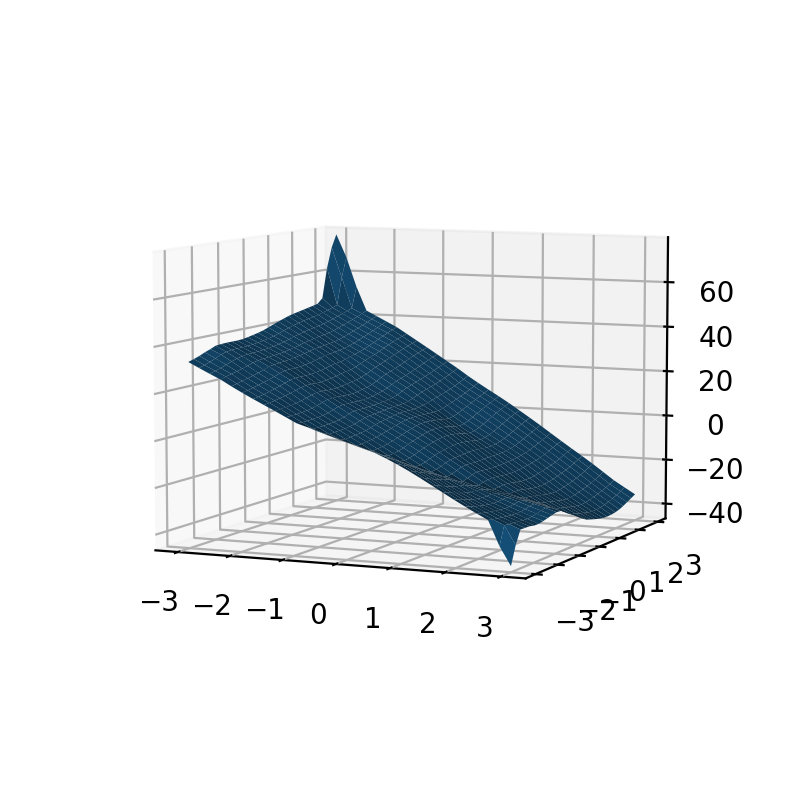

In [63]:
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), DCN(z[..., 0]))

<IPython.core.display.Javascript object>


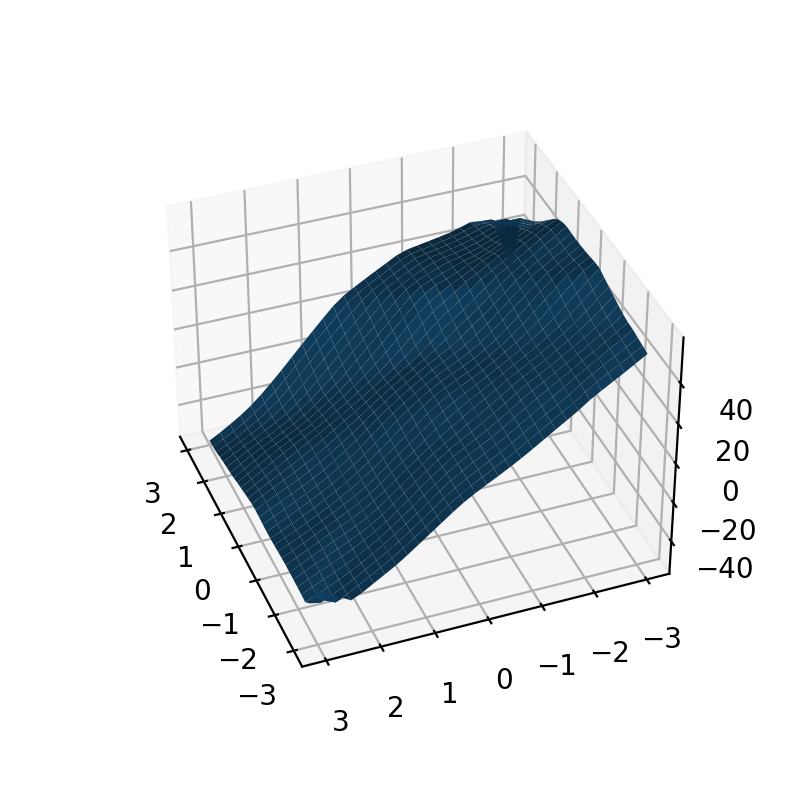

In [64]:
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), DCN(z[..., 1]))

<IPython.core.display.Javascript object>


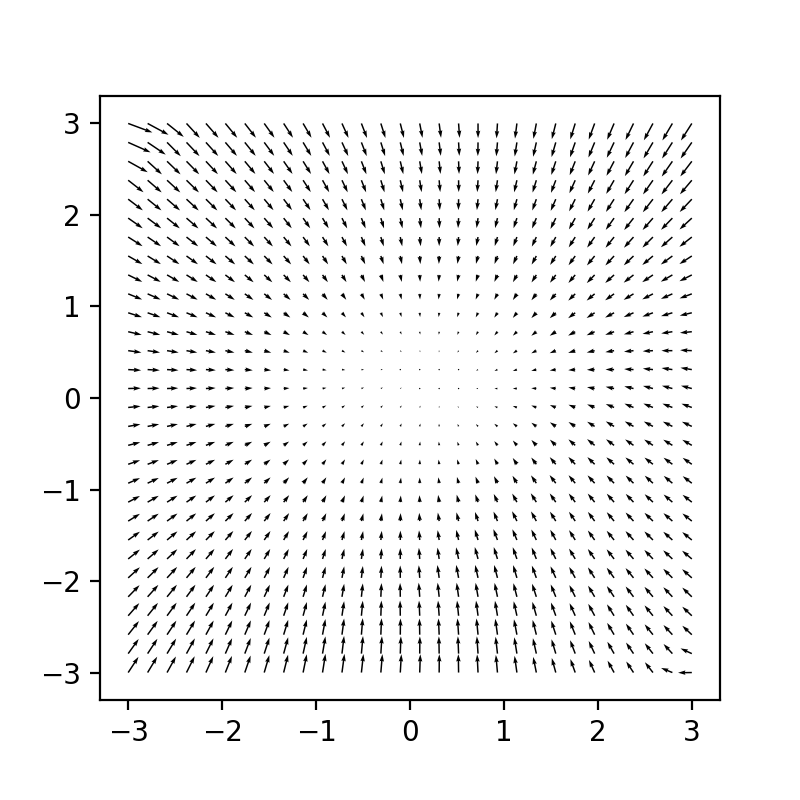

TypeError: hist2d() missing 2 required positional arguments: 'x' and 'y'

In [65]:
xs = torch.linspace(-3, 3, steps=30)
ys = torch.linspace(-3, 3, steps=30)
z = torch.zeros((30, 30))
w = torch.zeros((30, 30))
p = torch.zeros((30, 30))
q = torch.zeros((30, 30))
x, y = torch.meshgrid(xs, ys, indexing='xy')
index = [0, 1]
z = model.force_model(torch.cat((x.unsqueeze(-1).cuda(), y.unsqueeze(-1).cuda(), z.unsqueeze(-1).cuda()
                                , w.unsqueeze(-1).cuda(), p.unsqueeze(-1).cuda(), q.unsqueeze(-1).cuda()), dim=-1))[..., [index]].squeeze(2)
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111)
ax.quiver(x.numpy(), y.numpy(), DCN(z[..., 0]), DCN(z[..., 1]))
ax.hist2d()

In [68]:
scale_tril = torch.zeros(model.d, model.d).cuda()
scale_tril[model.diag_ind[0], model.diag_ind[1]] = 1 + F.elu(model.diag_param)
scale_tril[model.off_diag_ind[0], model.off_diag_ind[1]] = model.off_diag_param
diff_matrix = torch.matmul(scale_tril, scale_tril.T)
print(diff_matrix/20)

tensor([[ 1.2343,  0.9851,  0.2036, -0.1217,  0.1213, -0.0755],
        [ 0.9851,  2.0196,  0.2566, -0.1053,  0.0348, -0.4803],
        [ 0.2036,  0.2566,  1.2750, -1.0051,  0.1389,  0.1824],
        [-0.1217, -0.1053, -1.0051,  2.0311, -0.3319, -0.3214],
        [ 0.1213,  0.0348,  0.1389, -0.3319,  1.3016,  0.1718],
        [-0.0755, -0.4803,  0.1824, -0.3214,  0.1718,  1.4514]],
       device='cuda:0', grad_fn=<DivBackward0>)


## ETC

In [ ]:
# Set random seed for reproducibility
SEED = 2589
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

    
class FieldLearning(nn.Module):
    def __init__(self, d, dt):
        super(FieldLearning, self).__init__()
        self.d = d  # space dimension
        self.dt = torch.tensor(dt)
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.force_model = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),

        )
        self.diff_model = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        force = force_model(x)
        diff_matrix = diff_model()
        dx = force * self.dt + sqrtm(2 * diff_matrix) * torch.normal(mean=torch.zeros(self.d), std=torch.ones(self.d)) * torch.sqrt(self.dt)
        return dx